<a href="https://colab.research.google.com/github/K-space-Kishan/Machine-Learning-Stock-Market-Prediction-And-Forecasting-Using-Stacked-LSTM/blob/main/Stock_Market_Prediction_And_Forecasting_Using_Stacked_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Lets Begin***

### **Importing Required Libraries**

In [ ]:
import pandas_datareader as pdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy
from numpy import array
import seaborn as sns
import requests

# Extracting date & plotiting charts
import matplotlib.dates as mdates
!pip install mplfinance
import mplfinance as mpf
import datetime
from datetime import timedelta
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler

# Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import tensorflow as tf

# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error

### Loading Data

In [ ]:
# Your Tiingo API key
api_key = "702d9f0f19389c8fe5c5c58df6b3467b556893a0"

# Tiingo API endpoint for historical prices
url = f"https://api.tiingo.com/tiingo/daily/MSFT/prices"

# Parameters for the API request
params = {
    'startDate': '2019-09-10',
    'endDate': '2024-06-14',
    'token': api_key
}

# Fetch data from Tiingo
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    df = pd.DataFrame(data)
    df.head()
else:
    print(f"Failed to fetch data: {response.status_code}")

### **Data Wrangling**

In [ ]:
df

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2019-09-10T00:00:00.000Z,136.08,136.8900,134.510,136.800,28903378,130.201527,130.976536,128.699348,130.890424,28903378,0.0,1.0
1,2019-09-11T00:00:00.000Z,136.12,136.2700,135.090,135.910,24726117,130.239799,130.383319,129.254293,130.038870,24726117,0.0,1.0
2,2019-09-12T00:00:00.000Z,137.52,138.4200,136.870,137.850,27009981,131.579320,132.440442,130.957400,131.895065,27009981,0.0,1.0
3,2019-09-13T00:00:00.000Z,137.32,138.0600,136.570,137.780,23363057,131.387960,132.095993,130.670359,131.828089,23363057,0.0,1.0
4,2019-09-16T00:00:00.000Z,136.33,136.7000,135.660,135.830,16731440,130.440727,130.794743,129.799670,129.962326,16731440,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,2024-06-10T00:00:00.000Z,427.87,428.0800,423.890,424.700,14003034,427.870000,428.080000,423.890000,424.700000,14003034,0.0,1.0
1196,2024-06-11T00:00:00.000Z,432.68,432.8200,425.250,425.475,14551101,432.680000,432.820000,425.250000,425.475000,14551101,0.0,1.0
1197,2024-06-12T00:00:00.000Z,441.06,443.4000,433.250,435.320,22366233,441.060000,443.400000,433.250000,435.320000,22366233,0.0,1.0
1198,2024-06-13T00:00:00.000Z,441.58,443.3900,439.370,440.850,15960565,441.580000,443.390000,439.370000,440.850000,15960565,0.0,1.0


In [ ]:
df1=df.reset_index()['close']
df1

0       136.08
1       136.12
2       137.52
3       137.32
4       136.33
         ...  
1195    427.87
1196    432.68
1197    441.06
1198    441.58
1199    442.57
Name: close, Length: 1200, dtype: float64

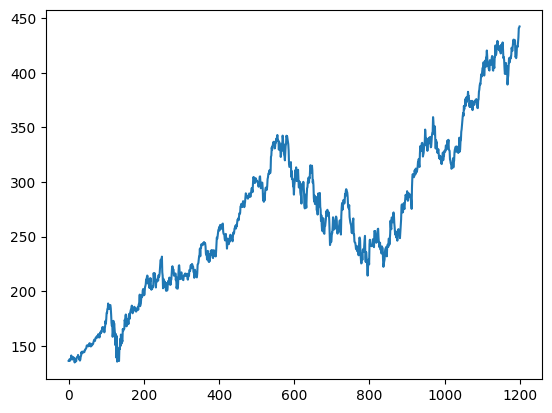

In [ ]:
plt.plot(df1)

 **Observation:**

* The plot shows the overall stock prices, and we can see how stock prices increased during Covid-19 and post Covid the share prices plumated, which later recovered.
* As per stock price prediction, data from Index No. 500 onwards will be sufficient for training our model.

In [ ]:
df=df[500:]
df.reset_index(drop=True, inplace=True)
df

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2021-09-02T00:00:00.000Z,301.15,303.3602,300.1800,302.200,16290545,294.096741,296.255175,293.149459,295.122148,16290545,0.0,1.0
1,2021-09-03T00:00:00.000Z,301.14,302.6000,300.2600,300.990,14751610,294.086975,295.512780,293.227585,293.940488,14751610,0.0,1.0
2,2021-09-07T00:00:00.000Z,300.18,301.0900,298.2000,301.005,17184083,293.149459,294.038146,291.215833,293.955137,17184083,0.0,1.0
3,2021-09-08T00:00:00.000Z,300.21,300.6100,297.4651,299.780,15046819,293.178756,293.569388,290.498145,292.758827,15046819,0.0,1.0
4,2021-09-09T00:00:00.000Z,297.25,302.1400,297.0000,300.820,19927000,290.288083,295.063554,290.043938,293.774470,19927000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,2024-06-10T00:00:00.000Z,427.87,428.0800,423.8900,424.700,14003034,427.870000,428.080000,423.890000,424.700000,14003034,0.0,1.0
696,2024-06-11T00:00:00.000Z,432.68,432.8200,425.2500,425.475,14551101,432.680000,432.820000,425.250000,425.475000,14551101,0.0,1.0
697,2024-06-12T00:00:00.000Z,441.06,443.4000,433.2500,435.320,22366233,441.060000,443.400000,433.250000,435.320000,22366233,0.0,1.0
698,2024-06-13T00:00:00.000Z,441.58,443.3900,439.3700,440.850,15960565,441.580000,443.390000,439.370000,440.850000,15960565,0.0,1.0


In [ ]:
df=df.copy()
df.insert(loc=df.columns.get_loc('date'), column='Date', value=df['date'].str.split('T').str[0])
# Convert the 'Date' column to datetime format if it's not already
df['Date'] = pd.to_datetime(df['Date'])
# Dropping the 'date' column
df.drop(columns=['date'], inplace=True)

In [ ]:
df

,Date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2021-09-02,301.15,303.3602,300.1800,302.200,16290545,294.096741,296.255175,293.149459,295.122148,16290545,0.0,1.0
1,2021-09-03,301.14,302.6000,300.2600,300.990,14751610,294.086975,295.512780,293.227585,293.940488,14751610,0.0,1.0
2,2021-09-07,300.18,301.0900,298.2000,301.005,17184083,293.149459,294.038146,291.215833,293.955137,17184083,0.0,1.0
3,2021-09-08,300.21,300.6100,297.4651,299.780,15046819,293.178756,293.569388,290.498145,292.758827,15046819,0.0,1.0
4,2021-09-09,297.25,302.1400,297.0000,300.820,19927000,290.288083,295.063554,290.043938,293.774470,19927000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,2024-06-10,427.87,428.0800,423.8900,424.700,14003034,427.870000,428.080000,423.890000,424.700000,14003034,0.0,1.0
696,2024-06-11,432.68,432.8200,425.2500,425.475,14551101,432.680000,432.820000,425.250000,425.475000,14551101,0.0,1.0
697,2024-06-12,441.06,443.4000,433.2500,435.320,22366233,441.060000,443.400000,433.250000,435.320000,22366233,0.0,1.0
698,2024-06-13,441.58,443.3900,439.3700,440.850,15960565,441.580000,443.390000,439.370000,440.850000,15960565,0.0,1.0


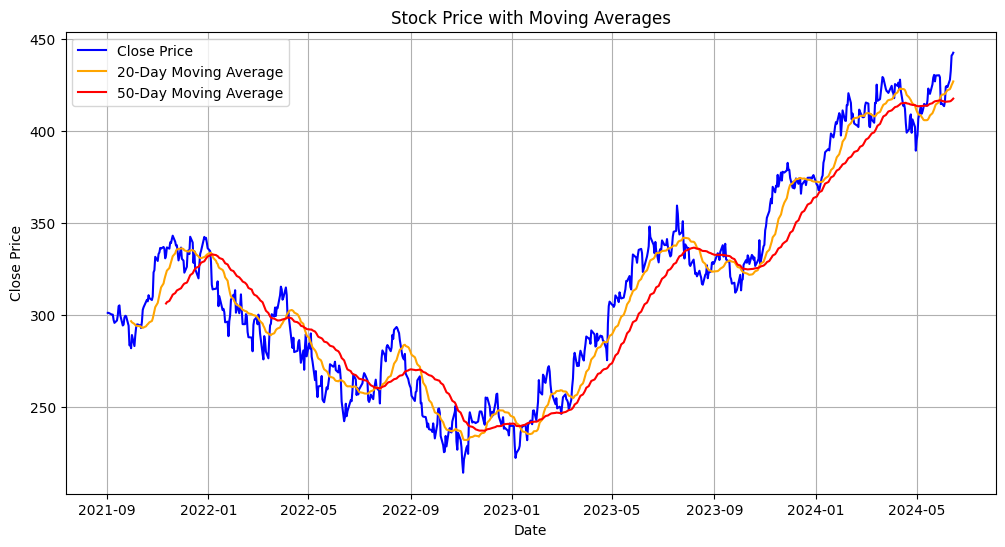

In [ ]:
df['20_day_MA'] = df['close'].rolling(window=20).mean()
df['50_day_MA'] = df['close'].rolling(window=50).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['close'], label='Close Price', color='blue')
plt.plot(df['Date'], df['20_day_MA'], label='20-Day Moving Average', color='orange')
plt.plot(df['Date'], df['50_day_MA'], label='50-Day Moving Average', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price with Moving Averages')
plt.legend()
plt.grid(True)
plt.show()

**Obseravtion:**
* This illustration is showing Moving Day Average (MDA), which showcases the average increase or decrease in share price in specifically 2 time periods, 20 Days & 50 Days average.
* Here Blue coloured line shows the share prices across time, while Yellow line shows the 20 Day MDA, and Red line shows 50 Dyas MDA.

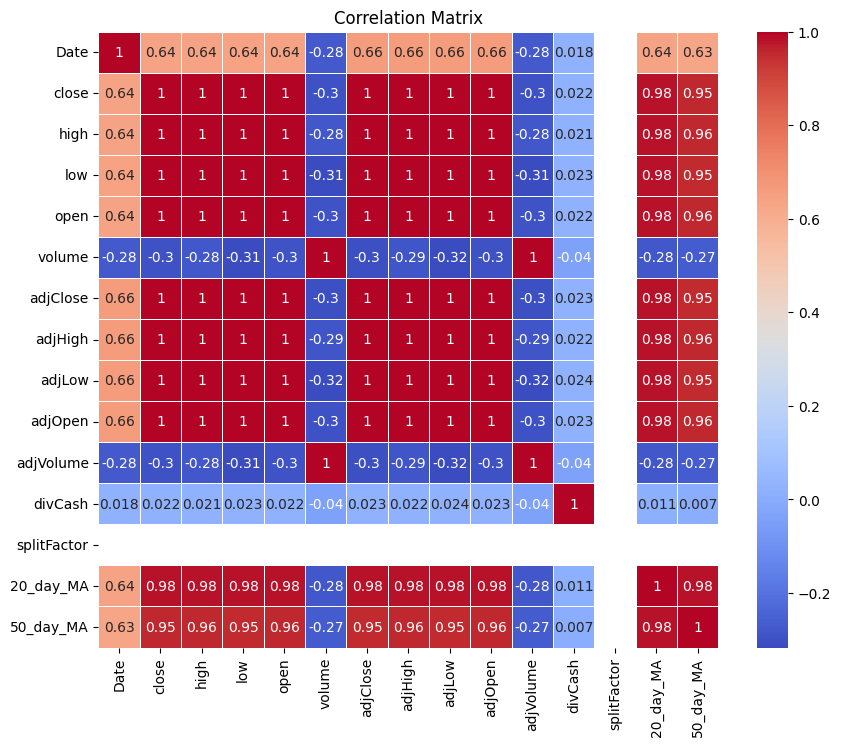

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

**Obseravtion:**
* Through this illustration we can see wthat if there is any relation between different features.

In [ ]:
df1=df.reset_index()[['Date','close']]
# Set 'date' as the index
df1.set_index('Date', inplace=True)
df1

,close
Date,
2021-09-02,301.15
2021-09-03,301.14
2021-09-07,300.18
2021-09-08,300.21
2021-09-09,297.25
...,...
2024-06-10,427.87
2024-06-11,432.68
2024-06-12,441.06


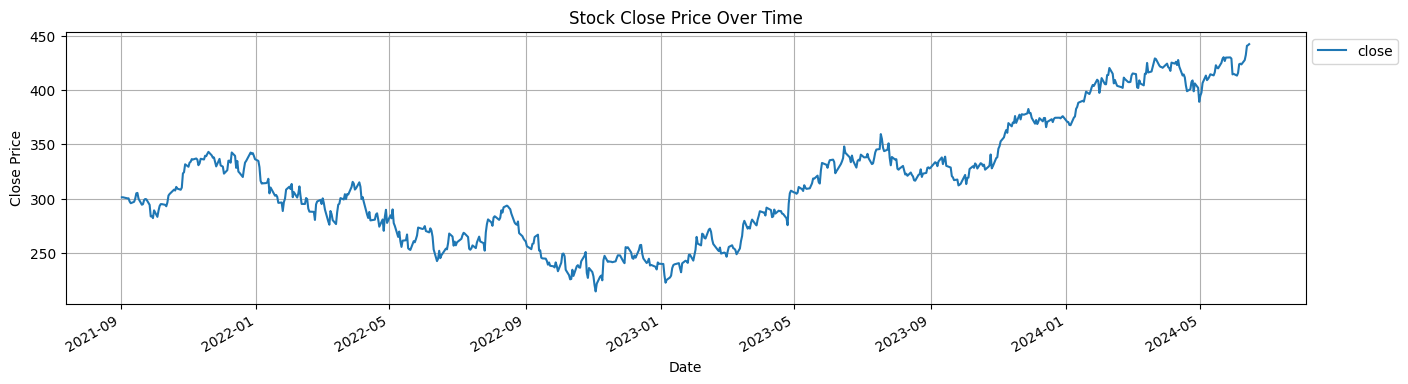

In [ ]:
# Plot the data
df1.plot(y='close', kind='line', figsize=(16, 4))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Close Price Over Time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

**Obseravtions:**
* The above plot shows the full chart from year 2021 to upcoming June of 2024.
* We can see that there is periodic fluctions in closing price, but if we see it alltogether, it clearly shows an increasing or upward trend.

### **Data Preprocessing**

**LSTM are sensitive to the scale of the data. so we apply MinMax scaler**

In [ ]:
#Standardizing the data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
df1

array([[0.38060617],
       [0.38056237],
       [0.37635774],
       [0.37648914],
       [0.36352488],
       [0.35677996],
       [0.36238612],
       [0.37464961],
       [0.3966801 ],
       [0.39843203],
       [0.375     ],
       [0.35060441],
       [0.35279432],
       [0.36935004],
       [0.37364226],
       [0.37272249],
       [0.35003504],
       [0.30338998],
       [0.30549229],
       [0.29638227],
       [0.32782936],
       [0.30159425],
       [0.32634022],
       [0.34539243],
       [0.35301331],
       [0.35301331],
       [0.35029783],
       [0.34438507],
       [0.35940785],
       [0.38761388],
       [0.39400841],
       [0.40749825],
       [0.41161528],
       [0.40802383],
       [0.42269622],
       [0.41568851],
       [0.4111773 ],
       [0.41984933],
       [0.47704975],
       [0.48221794],
       [0.51405922],
       [0.50420463],
       [0.52067274],
       [0.52448318],
       [0.53516994],
       [0.53350561],
       [0.53757884],
       [0.533

### Data Splitting

In [ ]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
training_size,test_size

(455, 245)

In [ ]:
train_data

array([[0.38060617],
       [0.38056237],
       [0.37635774],
       [0.37648914],
       [0.36352488],
       [0.35677996],
       [0.36238612],
       [0.37464961],
       [0.3966801 ],
       [0.39843203],
       [0.375     ],
       [0.35060441],
       [0.35279432],
       [0.36935004],
       [0.37364226],
       [0.37272249],
       [0.35003504],
       [0.30338998],
       [0.30549229],
       [0.29638227],
       [0.32782936],
       [0.30159425],
       [0.32634022],
       [0.34539243],
       [0.35301331],
       [0.35301331],
       [0.35029783],
       [0.34438507],
       [0.35940785],
       [0.38761388],
       [0.39400841],
       [0.40749825],
       [0.41161528],
       [0.40802383],
       [0.42269622],
       [0.41568851],
       [0.4111773 ],
       [0.41984933],
       [0.47704975],
       [0.48221794],
       [0.51405922],
       [0.50420463],
       [0.52067274],
       [0.52448318],
       [0.53516994],
       [0.53350561],
       [0.53757884],
       [0.533

### Data Transformation

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(354, 100)
(354,)


(None, None)

In [ ]:
print(X_test.shape), print(ytest.shape)

(144, 100)
(144,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### **ML Modeling and Implementation**

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
6/6 [==============================] - 16s 826ms/step - loss: 0.0425 - val_loss: 0.0258
Epoch 2/100
6/6 [==============================] - 3s 490ms/step - loss: 0.0115 - val_loss: 0.1241
Epoch 3/100
6/6 [==============================] - 3s 454ms/step - loss: 0.0096 - val_loss: 0.1235
Epoch 4/100
6/6 [==============================] - 2s 360ms/step - loss: 0.0059 - val_loss: 0.0244
Epoch 5/100
6/6 [==============================] - 1s 163ms/step - loss: 0.0065 - val_loss: 0.0545
Epoch 6/100
6/6 [==============================] - 1s 163ms/step - loss: 0.0050 - val_loss: 0.0393
Epoch 7/100
6/6 [==============================] - 1s 170ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 8/100
6/6 [==============================] - 1s 192ms/step - loss: 0.0037 - val_loss: 0.0087
Epoch 9/100
6/6 [==============================] - 1s 163ms/step - loss: 0.0036 - val_loss: 0.0045
Epoch 10/100
6/6 [==============================] - 1s 165ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 11

In [ ]:
# Predictions and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

5/5 [==============================] - 0s 31ms/step


In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
### Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train,train_predict))

272.2581022104679

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

412.5929097183064

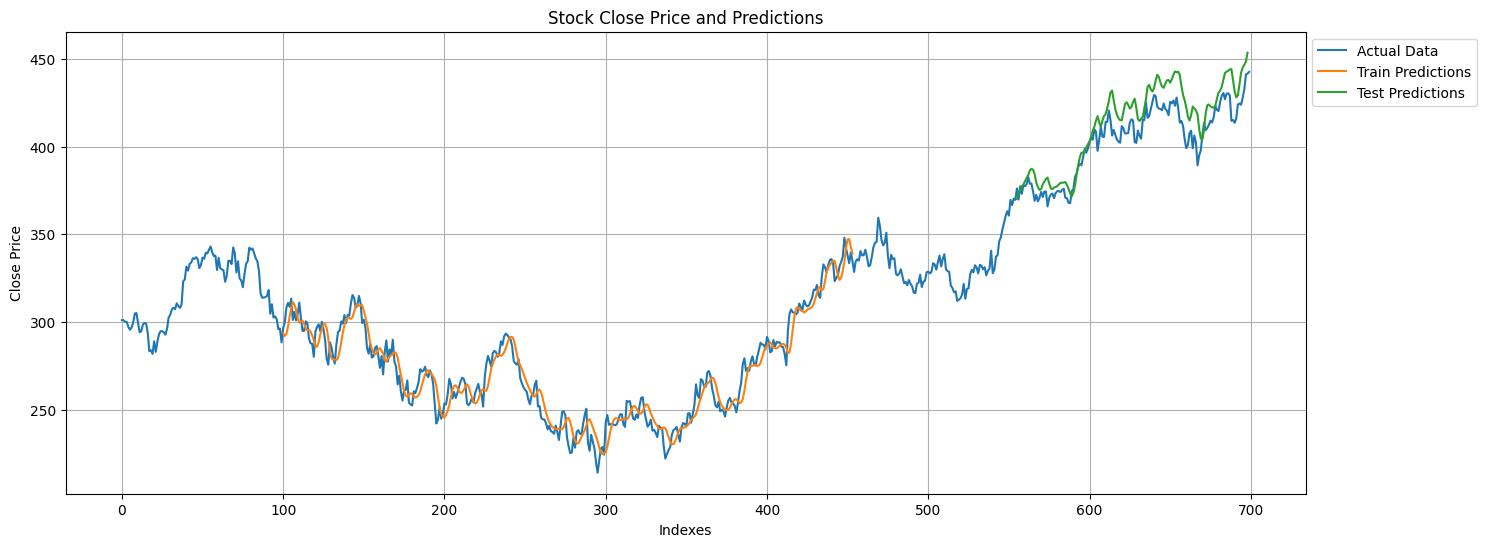

In [ ]:
# Set the look_back period
look_back = 100

# Initialize arrays for train and test predictions with NaN values
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:] = np.nan
testPredictPlot = np.empty_like(df1)
testPredictPlot[:] = np.nan

# Shift train predictions for plotting
trainPredictPlot[look_back:len(train_predict) + look_back] = train_predict

# Shift test predictions for plotting
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(df1) - 1] = test_predict

# Plot the baseline and predictions
plt.figure(figsize=(16, 6))
plt.plot(scaler.inverse_transform(df1), label='Actual Data')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.xlabel('Indexes')
plt.ylabel('Close Price')
plt.title('Stock Close Price and Predictions')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

**Obseravtion:**
* The above illustation shows the Original Stock price and also the Trained and Tested data.
* Blue colour plot shows the original stock price over time, while Orange coloured shows the Trained Prediction and Green colour shows the Test Prediction.

In [ ]:
len(test_data)

245

In [ ]:
x_input=test_data[145:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.8247634898388226,
 0.8348808689558515,
 0.8307638402242467,
 0.8561229852838123,
 0.8511737911702871,
 0.8029519971969165,
 0.8301068675543096,
 0.8626927119831816,
 0.8382971268395233,
 0.8375963559915908,
 0.8750875963559915,
 0.8753503854239663,
 0.9035564120532585,
 0.8803871758934828,
 0.8412316047652416,
 0.8551156271899089,
 0.8422827610371407,
 0.831333216538192,
 0.825770847932726,
 0.8230991590749824,
 0.8645760336370006,
 0.8588384723195513,
 0.8465749824807288,
 0.8463121934127541,
 0.8473633496846532,
 0.8732918710581637,
 0.8814383321653819,
 0.8788980378416259,
 0.8251576734407847,
 0.8227049754730201,
 0.853582690960056,
 0.8407936229852838,
 0.8333479327259984,
 0.8804747722494742,
 0.8796864050455501,
 0.9240101611772952,
 0.8854677645409951,
 0.8894096005606166,
 0.907323055360897,
 0.9240539593552909,
 0.9421864050455501,
 0.939427119831815,
 0.9136737911702874,
 0.9083742116327959,
 0.9074106517168886,
 0.9043009810791872,
 0.9211632796075683,
 0.907454449894884

### **Prediction ML Model**

In [ ]:
# demonstrate prediction for next 10 days
lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[1.0719208]
101
1 day input [0.83488087 0.83076384 0.85612299 0.85117379 0.802952   0.83010687
 0.86269271 0.83829713 0.83759636 0.8750876  0.87535039 0.90355641
 0.88038718 0.8412316  0.85511563 0.84228276 0.83133322 0.82577085
 0.82309916 0.86457603 0.85883847 0.84657498 0.84631219 0.84736335
 0.87329187 0.88143833 0.87889804 0.82515767 0.82270498 0.85358269
 0.84079362 0.83334793 0.88047477 0.87968641 0.92401016 0.88546776
 0.8894096  0.90732306 0.92405396 0.94218641 0.93942712 0.91367379
 0.90837421 0.90741065 0.90430098 0.92116328 0.90745445 0.90311843
 0.8918623  0.92532411 0.92125088 0.92865277 0.91542572 0.93587947
 0.90946917 0.87329187 0.8774089  0.8654082  0.83225298 0.80969692
 0.81775578 0.84670638 0.85323231 0.80934653 0.8412316  0.82340575
 0.7668185  0.79138928 0.80409075 0.84272074 0.87285389 0.85445865
 0.85971444 0.86751051 0.87810967 0.87364226 0.88608094 0.91463735
 0.90548353 0.90206727 0.92453574 0.94074107 0.9472232  0.93180624
 0.94564646 0.94634723 0.94131044 

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
len(df1)

700

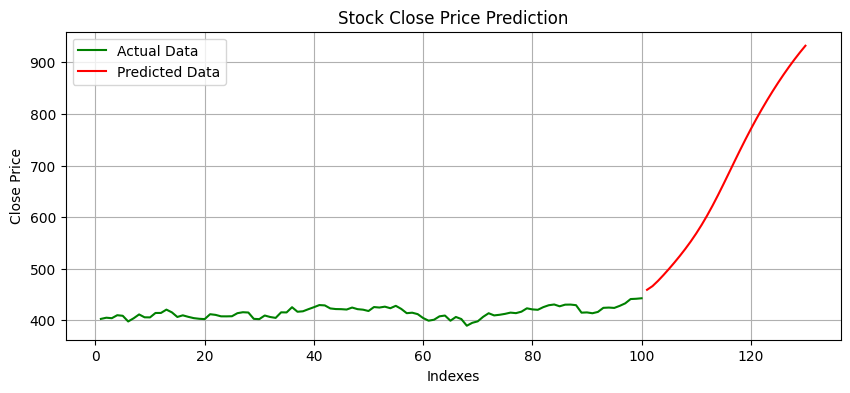

In [ ]:
# Plotting the actual data from a specific point (index 795)
plt.figure(figsize=(10, 4))  # Set figure size
plt.plot(day_new, scaler.inverse_transform(df1[600:]), label='Actual Data', color='green')

# Plotting the predicted data
plt.plot(day_pred, scaler.inverse_transform(lst_output), label='Predicted Data', color='red')

# Adding labels, title, and legend
plt.xlabel('Indexes')
plt.ylabel('Close Price')
plt.title('Stock Close Price Prediction')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

**Observation:**
* The plot shows the Stock Prediction, the Red coloured prediction shows predicted value and only the data of last 30 days is ploted.

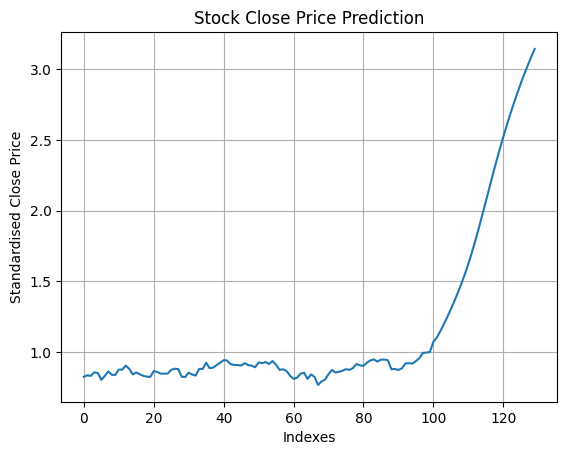

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[600:])
plt.xlabel('Indexes')
plt.ylabel('Standardised Close Price')
plt.title('Stock Close Price Prediction')
plt.grid(True)

In [ ]:
# Generate future dates for the predictions
last_date = df['Date'].iloc[-1]
num_predictions = len(lst_output)
future_dates = [last_date + timedelta(days=i) for i in range(1, num_predictions + 1)]
# Create a list of all dates by combining existing dates and future dates
all_dates = df['Date'].tolist() + future_dates

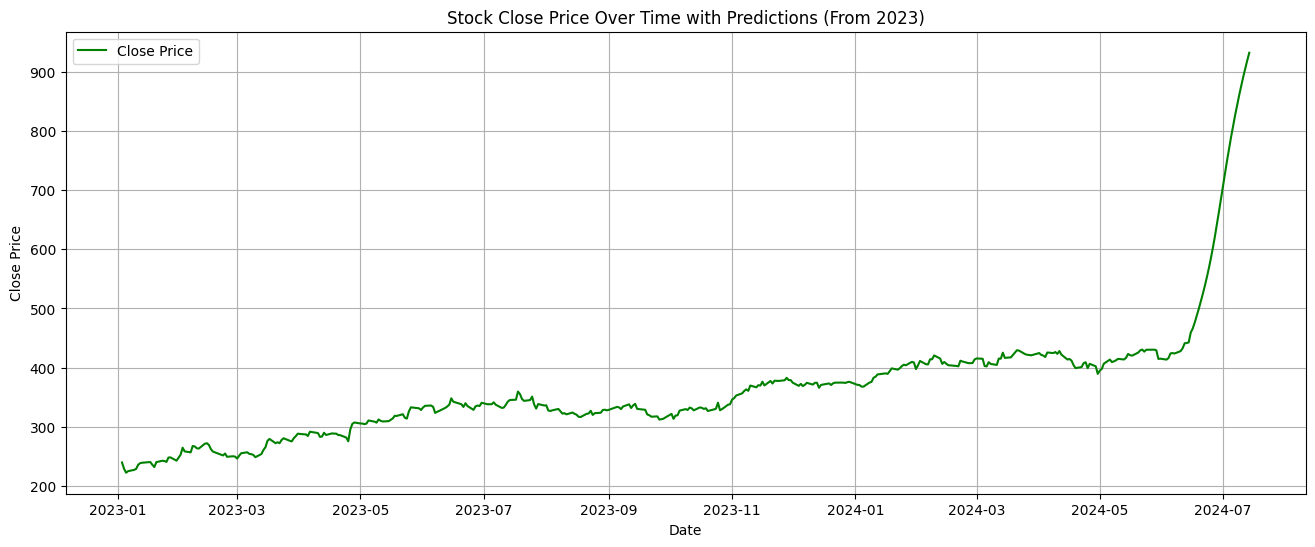

In [ ]:
df3=scaler.inverse_transform(df3).tolist()
# Filter the dates and close prices to include only those from 2023 onwards
start_date = pd.to_datetime('2023-01-01')
filtered_dates = [date for date in all_dates if date >= start_date]
filtered_close_prices = df3[len(all_dates) - len(filtered_dates):]

# Plot the filtered data
plt.figure(figsize=(16, 6))
plt.plot(filtered_dates, filtered_close_prices, label='Close Price', color='green')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Close Price Over Time with Predictions (From 2023)')
plt.legend()
plt.grid(True)
plt.show()

**Obseravtion:**
* The plot shows the overall stock price with the predicted value.
* This plot specifically shows the prediction with future dates, and using this it is predicted that stock prices will rise further.

## ***Conclusion***

> The goal of this Machine Learning project is to predict the share prices of specific organizations. For this demonstration, we selected Microsoft, a leading IT company.

> For training, we used data from the latter part of the available dataset, as six years of data is generally not necessary. Additionally, the short-term surge in share prices due to the COVID-19 pandemic could skew the model and result in inaccurate predictions, so this period was excluded from training.

> After training and testing our model, we predicted future share prices and plotted the results on a line graph. The model forecasts a continued increase in Microsoft's share prices in the upcoming future.

# ***End of Prediction ML Model***